# Models Pipeline

We want to see how different models affect our dataset.

In [6]:
from preprocessing import load_dataset, split_dataset, grid_search
import models
import matplotlib.pyplot as plt

We define the generic parameters, to be used to split the dataset.

In [7]:
test_size = 0.2         # the ratio of the dataset we want to use as test set
stratify = True         # Whether we want the split to keep the same proportion between classes as the original dataset
k = 5                   # The number of folds for the stratified k fold 

First of all, we load the dataset and we split it into training and test set (to be used only in the end).

In [8]:
# first, we load the dataset
X, y = load_dataset('./data/data.pkl')
# then, we split it
X_tr, y_tr, X_te, y_te = split_dataset(X, y, test=test_size, stratify=stratify)

Now, we can start to try the grid search with different models, to see how it behaves.

Notice we want to have high __*recall*__ for class 'MATCH' (that is, we want to detect as many MATCH samples as possible). For this reason, we put recall as main metric for our grid search.

## K-Nearest Neighbors

We run a grid search on the kNN model, trying values of k from 1 to 10. Since our data is highly dimensional, we expect such an algorithm to perform bad.

In [11]:
# get the grid and the model
model, grid = models.knn()
# call grid_search
out = grid_search(X_tr, y_tr, model, grid, k)

print("Best value of k (according to recall): " + str(out.best_params_['n_neighbors']))
print('-----------------------------------------')
print("Recall : " + str(out.best_score_))
print("Balanced accuracy: " + str(out.cv_results_['mean_test_balanced_accuracy'][out.best_index_]))
print("f1: " + str(out.cv_results_['mean_test_f1'][out.best_index_]))


Best value of k (according to recall): 1
-----------------------------------------
Recall : 0.19180066637693757
Balanced accuracy: 0.5125408355432569
f1: 0.18319940382603267


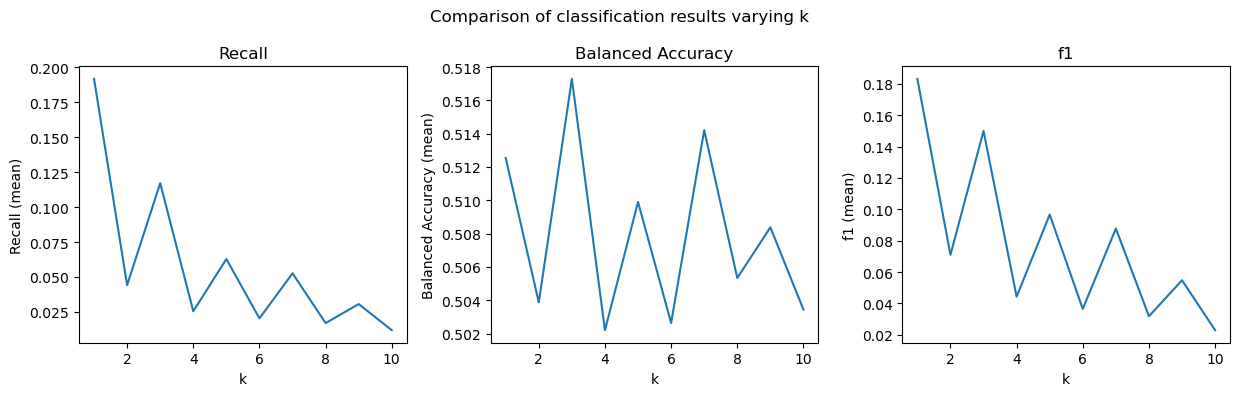

In [18]:
# Plot recall, balanced accuracy and f1 metric for every k in the range
k_range = list(range(1,11))

fig = plt.figure('kNN')
fig.set_size_inches(12.5, 4)
fig.suptitle("Comparison of classification results varying k")

# recall
plt.subplot(1,3,1)
plt.title("Recall")
plt.plot(k_range, out.cv_results_['mean_test_recall'])
plt.xlabel('k')
plt.ylabel('Recall (mean)')

# balanced accuracy
plt.subplot(1,3,2)
plt.title("Balanced Accuracy")
plt.plot(k_range, out.cv_results_['mean_test_balanced_accuracy'])
plt.xlabel('k')
plt.ylabel('Balanced Accuracy (mean)')

# f1
plt.subplot(1,3,3)
plt.title("f1")
plt.plot(k_range, out.cv_results_['mean_test_f1'])
plt.xlabel('k')
plt.ylabel('f1 (mean)')

fig.tight_layout()
plt.show()